In [32]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
import random


In [33]:
ZIP_PATH = "/content/Labeled Data-20251212T114953Z-3-001.zip"
DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(DATA_ROOT)

ROOT_DIR = os.path.join(DATA_ROOT, "Labeled Data")
print("Classes:", os.listdir(ROOT_DIR))


Classes: ['Nosyba', 'Ossama', 'Mohamed', 'Habiba Ayman', 'Ameen', 'Mark', 'Doha', 'Norhan', 'Abdallah Tamer', 'kareem', 'Kahla', 'Maryam EL-Haje', 'Bayomy', 'Hager Ali', 'Hamza', 'Anas', 'maryam', 'Marwan', 'maghol', 'Menna Omar', 'radwa', 'maghol 2', 'Hania Khaled', 'Roaa', 'Habib', 'shahd', 'Ahmed Amer', 'Rofida', 'Salma Wael', 'Raihana', 'Tokka']


In [34]:
class Equalize:
    def __call__(self, img):
        if not isinstance(img, Image.Image):
            raise TypeError("Input must be a PIL Image.")
        img_gray = img.convert("L")
        eq_gray = ImageOps.equalize(img_gray)
        eq_rgb = eq_gray.convert("RGB")
        return eq_rgb


In [35]:
train_transform = transforms.Compose([
    Equalize(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(ROOT_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class_names = train_dataset.classes
print("Number of classes:", len(class_names))

class_ids = {name: random.randint(1000,9999) for name in class_names}


Number of classes: 31


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Acc: {100*correct/total:.2f}%")

MODEL_PATH = "/content/face_model_trained.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model Trained and Saved Successfully")


Epoch [1/10] Loss: 2.0749 Acc: 57.94%
Epoch [2/10] Loss: 0.4611 Acc: 95.85%
Epoch [3/10] Loss: 0.1543 Acc: 99.37%
Epoch [4/10] Loss: 0.0743 Acc: 99.82%
Epoch [5/10] Loss: 0.0466 Acc: 99.91%
Epoch [6/10] Loss: 0.0351 Acc: 99.91%
Epoch [7/10] Loss: 0.0219 Acc: 100.00%
Epoch [8/10] Loss: 0.0179 Acc: 100.00%
Epoch [9/10] Loss: 0.0152 Acc: 100.00%
Epoch [10/10] Loss: 0.0132 Acc: 99.91%
Model Trained and Saved Successfully


In [38]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

test_transform = transforms.Compose([
    Equalize(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [39]:
def predict_face(face_img, threshold=0.7):
    if face_img is None or face_img.size == 0:
        return "Unknown", None

    img = Image.fromarray(face_img).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        conf, class_id = probs.max(1)
        conf = conf.item()
        class_id = class_id.item()

    if conf >= threshold:
        name = class_names[class_id]
        return name, class_ids[name]
    else:
        return "Unknown", None

In [55]:
def recognize_and_show_faces(image_path, threshold=0.2, iou_threshold=0.2, min_face_size=100):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Image not found")

    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(min_face_size, min_face_size)
    )

    def iou(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        xi1 = max(x1, x2)
        yi1 = max(y1, y2)
        xi2 = min(x1+w1, x2+w2)
        yi2 = min(y1+h1, y2+h2)
        inter_area = max(0, xi2-xi1) * max(0, yi2-yi1)
        box1_area = w1*h1
        box2_area = w2*h2
        union_area = box1_area + box2_area - inter_area
        return inter_area / union_area if union_area > 0 else 0

    keep = []
    for i, box in enumerate(faces):
        keep_flag = True
        for k in keep:
            if iou(box, faces[k]) > iou_threshold:
                keep_flag = False
                break
        if keep_flag:
            keep.append(i)

    faces = [faces[i] for i in keep]
    print(f"Found {len(faces)} faces after NMS")

    face_imgs = []
    names = []

    for i, (x,y,w,h) in enumerate(faces):
        face_crop = img[y:y+h, x:x+w]
        if face_crop.size == 0:
            continue
        name, cid = predict_face(face_crop, threshold)
        display_name = f"{name} (ID:{cid})" if cid is not None else name
        face_imgs.append(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
        names.append(display_name)
        print(f"Face {i+1}: {display_name}")

    n = len(face_imgs)
    if n == 0:
        print("No faces detected.")
        return

    plt.figure(figsize=(4*n,5))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.text(0.5, -0.2, names[i], fontsize=12, ha='center')
        plt.imshow(face_imgs[i])
        plt.axis('off')
    plt.show()


Found 11 faces after NMS
Face 1: Unknown
Face 2: Unknown
Face 3: Unknown
Face 4: Unknown
Face 5: Unknown
Face 6: Unknown
Face 7: Salma Wael (ID:8315)
Face 8: Habiba Ayman (ID:5094)
Face 9: Unknown
Face 10: radwa (ID:2519)
Face 11: shahd (ID:4605)


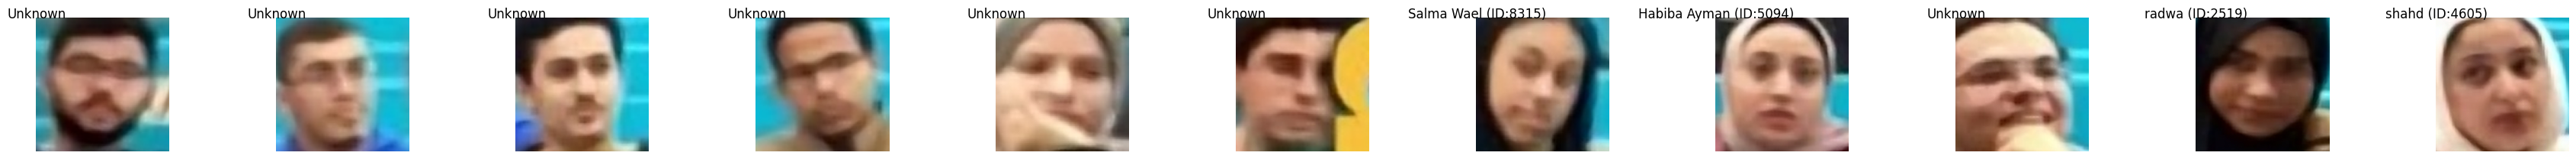

In [58]:
recognize_and_show_faces("/content/frame_038 (4).jpg", threshold=0.6)
